In [26]:
import librosa
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import time
import os

In [28]:
test_file = "sd.mp3"
t, sr = librosa.load(test_file)

/home/hesham/.local/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [31]:
org_size = os.path.getsize(test_file)
print(org_size / 1e6)

5.139154


In [21]:
def audio_to_mdb(t, sr, n_m=129):
    mpw = librosa.feature.melspectrogram(y=t, sr=sr,n_fft=2048, hop_length=512, n_mels=n_m)
    mdb = librosa.power_to_db(mpw, ref=np.max)
    return mdb, np.max(mpw)

def mdb_to_audio(mdb, max_pw=1):
    mpw = librosa.db_to_power(mdb)
    mel_inv = librosa.feature.inverse.mel_to_stft(mpw)
    # sqrt of max power is max amplitude in stft
    # this preserves the volume without slowing down mel_to_stft by denormalizing mpw
    t = librosa.griffinlim(mel_inv * np.sqrt(max_pw))
    return t

def mdb_to_img(mdb):
    a = mdb.transpose().reshape((-1, 3)).copy()
    p = int(np.ceil(np.sqrt(a.shape[0])))
    a.resize(p*p*3)
    b = a.reshape((p,p,3))
    i = b / -80
    return i

def img_to_mdb(i, m_n=129):
    b = i * -80
    a = b.reshape((-1)).copy()
    a.resize(a.shape[0] - a.shape[0] % m_n)
    a = a.reshape((-1, 3))
    mdb = a.reshape((-1, m_n)).transpose()
    return mdb

def audio_to_img(t, sr):
    mdb, max_pw = audio_to_mdb(t, sr)
    return {'img': mdb_to_img(mdb), 'sr': sr, 'max_pw': max_pw}

def img_to_audio(imudio):
    img = imudio['img']
    if np.max(img) > 1:
        img = img.copy() / 255.0
    mdb = img_to_mdb(img)
    t = mdb_to_audio(mdb, imudio['max_pw'])
    return t, imudio['sr']

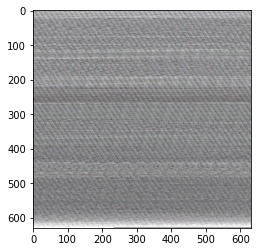

In [4]:
imudio = audio_to_img(t, sr)
plt.imshow(imudio['img'])

In [64]:
est = imudio['img'].ravel().shape[0] * 4
print("%.2fMB > %.2fMB ~ %.2f%%" % (org_size / 1e6, est / 1e6, (est / org_size * 100)))

5.14MB > 4.76MB ~ 92.68%


Raw data size (1 float is 4 bytes)

## JPEG

In [33]:
import imageio
jpg_file = 'test.jpg'
imageio.imwrite(jpg_file, imudio['img'])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [41]:
from PIL import Image
jpg = Image.open(jpg_file)
jpg_size = os.path.getsize(jpg_file)
print("%.2fMB > %.2fMB ~ %.2f%%" % (org_size / 1e6, jpg_size / 1e6, (jpg_size / org_size * 100)))

5.14MB > 0.15MB ~ 2.85%


Too good to work.

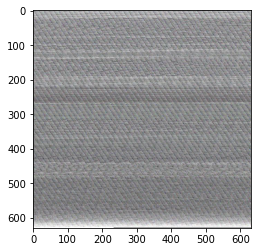

In [7]:
from copy import deepcopy
imudio_jpg = deepcopy(imudio)
imudio_jpg['img'] = np.array(jpg)
plt.imshow(imudio_jpg['img'])

In [22]:
t_jpg, sr = img_to_audio(imudio_jpg)

In [23]:
sd.play(t_jpg, sr)

In [24]:
sd.stop()

Haunting quality but somehow has the "skeleton" of the song tones.

## Pickle

In [47]:
import pickle
pkl_file = 'test.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(imudio, f)
pkl_size = os.path.getsize(pkl_file)
print("%.2fMB > %.2fMB ~ %.2f%%" % (org_size / 1e6, pkl_size / 1e6, (pkl_size / org_size * 100)))

5.14MB > 4.76MB ~ 92.68%


Nothing magical here, just a minimal binary dump to confirm estimate size.

## PNG

In [48]:
png_file = 'test.png'
imageio.imwrite(png_file, imudio['img'])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [49]:
png = Image.open(png_file)
png_size = os.path.getsize(png_file)
print("%.2fMB > %.2fMB ~ %.2f%%" % (org_size / 1e6, png_size / 1e6, (png_size / org_size * 100)))

5.14MB > 1.03MB ~ 20.14%


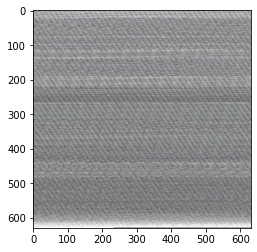

In [50]:
imudio_png = deepcopy(imudio)
imudio_png['img'] = np.array(png)
plt.imshow(imudio_png['img'])

In [51]:
t_png, sr = img_to_audio(imudio_jpg)

In [52]:
sd.play(t_png, sr)

In [53]:
sd.stop()

Still unacceptable.

## BMP

In [54]:
bmp_file = 'test.bmp'
imageio.imwrite(bmp_file, imudio['img'])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [68]:
bmp = Image.open(bmp_file)
bmp_size = os.path.getsize(bmp_file)
print("%.2fMB > %.2fMB ~ %.2f%%" % (org_size / 1e6, bmp_size / 1e6, (bmp_size / org_size * 100)))

5.14MB > 1.19MB ~ 23.19%


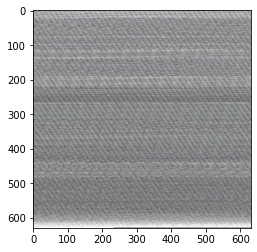

In [56]:
imudio_bmp = deepcopy(imudio)
imudio_bmp['img'] = np.array(bmp)
plt.imshow(imudio_bmp['img'])

In [57]:
t_bmp, sr = img_to_audio(imudio_bmp)

In [65]:
sd.play(t_bmp, sr)

Promising!

In [78]:
sd.stop()

In [77]:
sd.stop()
sd.play(t, sr)